In [48]:
import torch
import torch.nn as nn


# -------------------------------
#   Bottleneck Block (ResNet-50)
# -------------------------------

class Bottleneck(nn.Module):
    expansion = 4   # output channels expanded by 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # projection shortcut (1×1 conv) if needed
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity   # skip connection
        out = self.relu(out)

        return out

In [49]:
# -------------------------------
#     ResNet-50 Architecture
# -------------------------------

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.in_channels = 64

        # --- initial conv + maxpool ---
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # --- ResNet layers ---
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # --- classification head ---
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Initialize weights (optional)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    # Build each stage: (1x1, 3x3, 1x1) blocks repeated L times
    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None

        # If shape changes (channels or stride), need projection shortcut
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,
                          out_channels * block.expansion,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # 3 bottlenecks
        x = self.layer2(x)  # 4 bottlenecks
        x = self.layer3(x)  # 6 bottlenecks
        x = self.layer4(x)  # 3 bottlenecks

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [50]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(size=(224,224))])

train_set = datasets.ImageFolder("/Users/benjaminbrooke/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1/original_data_set/train_data", transform=transforms)

train_loader = DataLoader(train_set, batch_size=16, shuffle = True)

In [51]:
model_one = ResNet(Bottleneck,[1,1,1,1],num_classes=6)

In [52]:
optimizer = torch.optim.Adam(model_one.parameters(),lr=0.01)

In [53]:
loss_fn = nn.CrossEntropyLoss()

In [54]:
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

writer = SummaryWriter()

epochs = 3

step = 0

for epoch in tqdm(range(epochs),desc="Epochs"):

    model_one.train()

    running_loss = 0
    train_loader = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)

    for X_train, y_train in train_loader:

        optimizer.zero_grad()

        y_pred = model_one(X_train)

        loss = loss_fn(y_pred, y_train)

        loss.backward()

        optimizer.step()


        preds = y_pred.argmax(dim=1)
        acc = (preds == y_train).float().mean().item()

        writer.add_scalar("Loss/train", loss.item(), step)
        writer.add_scalar("Accuracy/train", acc, step)

        step = step + 1


        train_loader.set_postfix(loss=loss.item(), acc=acc)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/3]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch [2/3]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch [3/3]:   0%|          | 0/96 [00:00<?, ?it/s]

In [55]:
writer.close()

In [57]:
%load_ext tensorboard
%tensorboard --logdir="/Users/benjaminbrooke/PycharmProjects/Python_PyTroch/PyTorch Practice/Neural Networks/runs/Nov30_21-02-58_Benjamins-MacBook-Air.local"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [63]:
classes = [
    "freshbanana", "freshapples", "freshoranges",
    "rottenbanana", "rottenapples", "rottenoranges"
]

In [71]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(size=(224,224))])

test_set = datasets.ImageFolder("/Users/benjaminbrooke/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1/original_data_set/test_data", transform=transforms)

test_loader = DataLoader(test_set, batch_size=1, shuffle = True)

model_one.eval()

acc_list = []

i = 0

for X_test, y_test in test_loader:

    y_pred = model_one(X_test)

    loss = loss_fn(y_pred, y_test)

    preds = y_pred.argmax(dim=1)

    acc = (preds == y_test).float().mean().item()

    acc_percent = (preds == y_test).float().mean().item()

    acc_list.append(acc)

    if classes[y_test.item()] == classes[preds.item()]:
        i = i + 1

    print(f"Predicted fruit: {classes[preds.item()]},      Actual fruit:  {classes[y_test.item()]}", classes[y_test.item()] == classes[preds.item()] )

Predicted fruit: freshoranges,      Actual fruit:  rottenbanana False
Predicted fruit: rottenapples,      Actual fruit:  rottenapples True
Predicted fruit: freshapples,      Actual fruit:  freshapples True
Predicted fruit: rottenapples,      Actual fruit:  rottenapples True
Predicted fruit: freshoranges,      Actual fruit:  rottenoranges False
Predicted fruit: freshoranges,      Actual fruit:  freshbanana False
Predicted fruit: freshoranges,      Actual fruit:  rottenbanana False
Predicted fruit: rottenapples,      Actual fruit:  rottenapples True
Predicted fruit: freshoranges,      Actual fruit:  freshbanana False
Predicted fruit: freshoranges,      Actual fruit:  freshbanana False
Predicted fruit: freshapples,      Actual fruit:  freshbanana False
Predicted fruit: rottenbanana,      Actual fruit:  rottenbanana True
Predicted fruit: rottenbanana,      Actual fruit:  rottenoranges False
Predicted fruit: freshoranges,      Actual fruit:  rottenbanana False
Predicted fruit: rottenbanana,

In [72]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(size=(224,224))])

test_set = datasets.ImageFolder("/Users/benjaminbrooke/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1/original_data_set/test_data", transform=transforms)

test_loader = DataLoader(test_set, batch_size=20, shuffle = True)

model_one.eval()

acc_list = []

i = 0

for X_test, y_test in test_loader:

    y_pred = model_one(X_test)

    loss = loss_fn(y_pred, y_test)

    preds = y_pred.argmax(dim=1)

    acc_percent = (preds == y_test).float().mean().item()

    acc_list.append(acc_percent)


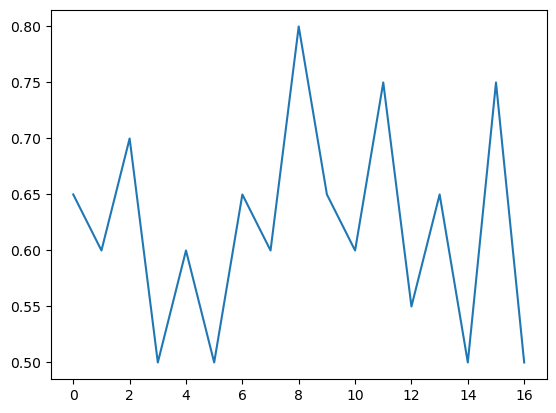

In [73]:
import matplotlib.pyplot as plt



plt.plot(list(range(len(test_loader))), acc_list)